In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interactive, fixed, IntSlider


from PIL import Image
from matplotlib.patches import Rectangle


import soundfile as sf
from IPython.display import display
from IPython.display import Audio

## 1 Vzorek siglálů

tbd

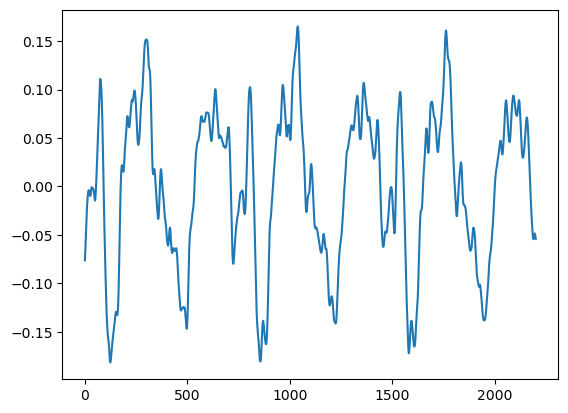

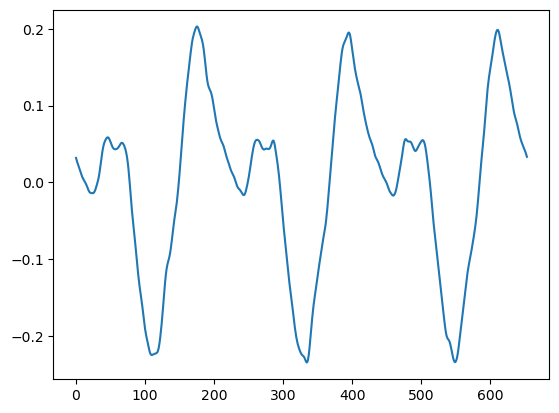

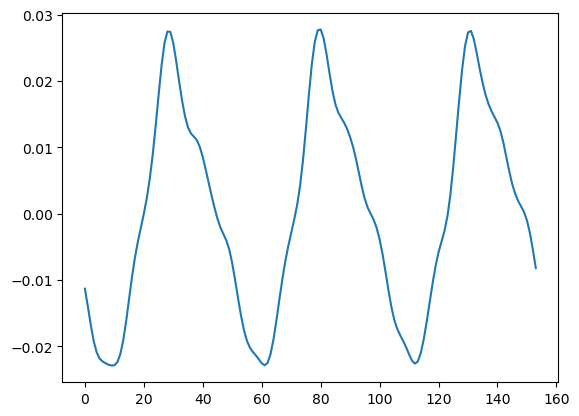

In [38]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read("klavir.wav")
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N))  # matrix with all tones - first signals empty,
                                # but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
i = 24
a = 1
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
    #autocorr = np.correlate(xall[a], xall[a], mode = 'full')[len(x)-1]
    #print(i, autocorr, file=open('output.txt', 'a'))
    i += 1
    a += 1
    

#sf.write("a_orig.wav", xall[40], Fs)
#sf.write("b_orig.wav", xall[57], Fs)
#sf.write("c_orig.wav", xall[82], Fs)
plt.plot(xall[40,:int(3*Fs//82.41)])
plt.show()
plt.plot(xall[57,:int(3*Fs//220.00)])
plt.show()
plt.plot(xall[82,:int(3*Fs//932.33)])
plt.show()


c:\Users\jirmu\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


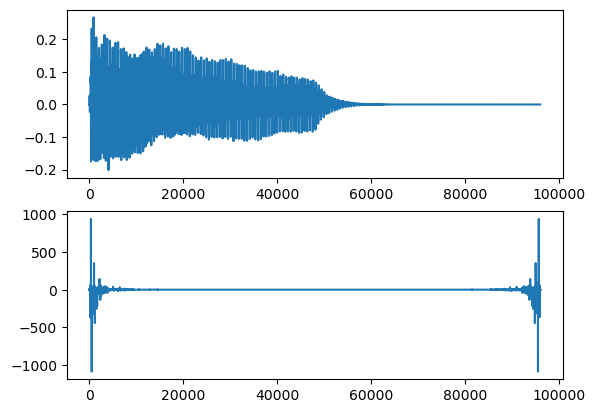

In [39]:
tone, Fs = sf.read("klavir.wav")
plt.figure()
plt.subplot(211)
num = 40
midi = 24
sample = 2*Fs
tmp = sample * (num - midi)
wave = tone[tmp : tmp + sample]
plt.plot(wave)
plt.subplot(212)
dft = np.fft.fft(wave)
plt.plot(dft)
plt.show()